In [106]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math

# FUNÇAO QUE CONVERTE O FORMATO DO dtEVENTO NO ARQUIVO BASE_TREINAMENTO.CSV
# O FORMATO DAS DATAS NO CSV É DIFERENTE DAQUELE QUE ESTA NO NOME DOS ARQUIVOS
def timeConverter(DataFrame):
    dtEvento = []
    for i in range(0, 6966):
        aux = DataFrame.iloc[i, 4].replace(' ', '_')
        aux = aux.replace('-', '')
        dtEvento.append(aux.replace(':', ''))
        
    return dtEvento

# FUNÇAO QUE CONVERTE OS VALORES DE STRING PARA FLOAT
# OS DADOS DISPONIBILIZADOS ESTÃO TODOS EM TXT
def stringToFloat(dataFrame, nome):
    dataFrame[nome] = pd.to_numeric(dataFrame[nome], downcast="float")

    
# FUNÇAO QUE OBTEM OS DADOS DE CORRENTE RMS DE CADA UMA DAS ASSINATURAS
def getDados(Leitura, tipoDeDado):
    f = open(Leitura) # pode ser adicionado o .txt, mas ele ja esta presente nas colunas
    lines = f.readlines()
    i = 0
    while(i < len(lines)):
        i += 1
        if(lines[i] == "***End_of_Header***\n"):
            break
    
    Inicio = i + 2
    with open(Leitura) as f:
        linhas = f.readlines()[Inicio:]
    df = pd.DataFrame(linhas)
    df = df[0].str.split('\t', expand=True)
    stringToFloat(df, 2)
    
    if(tipoDeDado == 'tempo'):
        return np.array(df[0])
    if(tipoDeDado == 'corrente'):
        return np.array(df[1])
    if(tipoDeDado == 'correnteRMS'):
        return np.array(df[2])
    
def getLeituras(maquinas, amostragem, maquinaAnalisada):
    for i in range(0, int(len(maquinas.index))):  
        try:
            leitura = getDados(maquinas['DS_LOCAL_INSTALACAO'].iloc[i] + '/' + maquinas['DS_ATIVO_SAP'].iloc[i] + '_'  + maquinas['DS_POS_CMD'].iloc[i]  + '_' + maquinas['DT_EVENTO'].iloc[i] + '.txt', 'correnteRMS')
        except FileNotFoundError:
            print("Leitura não encontrada: " + maquinas['DS_ATIVO_SAP'].iloc[i] + '_'  + maquinas['DS_POS_CMD'].iloc[i]  + '_' + maquinas['DT_EVENTO'].iloc[i] + '.txt')
        else:
            DF = pd.DataFrame(leitura, columns=[maquinas['DS_ATIVO_SAP'].iloc[i] + '_' + maquinas['DT_EVENTO'].iloc[i]])
            stringToFloat(DF, maquinas['DS_ATIVO_SAP'].iloc[i] + '_' + maquinas['DT_EVENTO'].iloc[i])
            DF = DF.transpose()
            maquinaAnalisada = pd.concat([maquinaAnalisada, DF,])
    maquinaAnalisada = maquinaAnalisada.transpose()
        
    return maquinaAnalisada
        

In [243]:
# Filtro de dados

# FUNÇAO QUE FILTRA AS LEITURAS ZERADAS OU QUE APRESENTAM COMPORTAMENTO DE PEQUENOS RUIDOS
# EXEMPLO DE LEITURA EM QUE ISSO ACONTECE: MCH004W21A_R_20190906_104250
def filtroLeiturasRuido(Maquinas):
    max = 0
    leiturasRuido = []
    for i in range(1, len(Maquinas.columns)):
        for j in range(0, len(Maquinas.index)):
            if(max <= Maquinas.iloc[j, i]):
                max = Maquinas.iloc[j, i]
        if(max < 1):
            leiturasRuido.append(Maquinas.columns[i])
        max = 0
    
    Maquinas = Maquinas.drop(leiturasRuido, axis=1)
    return Maquinas 

# FUNÇAO QUE CORRIGE AS LEITURAS CUJAS CORRENTES SOFRERAM A REDUÇAO PELO FILTRO QUE O GUILHERME COMENTOU
def corrigeCorrentes(Maquinas, fatorDeCorrecao):
    max = 0
    aux = 0
    for i in range(1, len(Maquinas.columns)):
        for j in range(0, len(Maquinas.index)):
            if(max <= Maquinas.iloc[j, i]):
                max = Maquinas.iloc[j, i]
        if(max < 12):
            Maquinas[Maquinas.columns[i]] = fatorDeCorrecao*Maquinas[Maquinas.columns[i]]
        max = 0
    
    return Maquinas

# FILTRO DE LEITURAS DESLOCADAS PARA TRAÇAR A MEDIA
# Se o filtro não é utilizado, as curvas médias apresentam um comportamento bizarro, as médias não consideram deslocamento
def filtroLeituraDeslocada(leituras, dfPontosFase):
    leiturasFiltradas = []
    if(dfPontosFase.iloc[0,0] != None):
        moda = dfPontosFase.mode(axis=1)
        
        for i in range(0, len(dfPontosFase.columns)):
            if(dfPontosFase.iloc[0, i] > moda.iloc[0,0]*1.1 or dfPontosFase.iloc[0, i] < moda.iloc[0,0]/1.1): # filtra leituras cujo valor de fim da fase 0 é 40% maior que o valor mínimo
                leiturasFiltradas.append(dfPontosFase.columns[i])

        leituras = leituras.drop(leiturasFiltradas, axis=1)
    else:
        print('Não há leituras normais')
    return leituras

In [244]:
# Cálculo com Dados

def Derivada(valor, intervalo):
    derivada = np.diff(valor.values)/intervalo    #pode ser alterado pra utilizar a coluna do tempo ao inves de um intervalo 
    return derivada
    pd.set_option('display.max_rows', 300)
    
def calculaFases(corrente, intervalo):
    deriv = np.array(Derivada(corrente, intervalo))
    corrente = np.array(corrente)
    fimFases = []
    fimFase0 = np.argmax(deriv[50:]>10) + 50
    fimFases.append(fimFase0)
    topo = 0
    topo = np.argmax(deriv[fimFase0:]<0)
    topo = topo + fimFase0
    
   
    metadeCorrente = np.argmax(corrente[topo:]<(corrente[topo]/2))  + topo
    fimFase1 = np.argmax(deriv[metadeCorrente + 1:]>-4)
    fimFase1 = fimFase1 + metadeCorrente + int(0.04545/intervalo)
    fimFases.append(fimFase1)
    #
    #descomentar quado se tratar de leituras novas
    #result = np.where(deriv[fimFase1 + int(0.15/intervalo):] == np.amin(deriv[fimFase1 + int(0.15/intervalo):fimFase1 + int(0.5/intervalo)]))
    #fimFase2 = result[0][0] + int(0.04/intervalo) + fimFase1 + int(0.15/intervalo)
    #fimFases.append(fimFase2)
    result = np.where(deriv == np.amax(deriv[fimFase1 + int(0.9/intervalo):fimFase1 + int(2/intervalo)]))
    fimFase3 = result[0][0] - int(0.04040/intervalo)
    fimFases.append(fimFase3)
    

    fimCorrente = np.argmax(corrente[fimFase3:]<(corrente[topo]/20)) + fimFase3
    fimFase4 = np.argmax(deriv[fimCorrente + 1:] > -1)
    fimFase4 = fimCorrente + fimFase4 - int(0.02020/intervalo)
    fimFases.append(fimFase4)
    return (fimFases)

# FUNÇAO QUE GERA UM GRAFICO COM AS CURVAS MEDIA, MAXIMA E MINIMA
def geraAssinaturaMedia(maquinaEmAnalise, parametroStd):
    assinaturaNormal = pd.DataFrame()
    dfex = maquinaEmAnalise
    assinaturaNormal = assinaturaNormal.assign(Tempo = lambda x: dfex['t (s)']) 
    dfex = dfex.drop("t (s)", axis=1)
    stdNormal = dfex.std(axis=1)
    mediaNormal = dfex.mean(axis=1)
    assinaturaNormal['Std'] = stdNormal
    assinaturaNormal['Média'] = mediaNormal
    assinaturaNormal['Curva mínima'] = mediaNormal - parametroStd*stdNormal
    assinaturaNormal['Curva máxima'] = mediaNormal + parametroStd*stdNormal
    dfex.shape
    for i in range(0, len(assinaturaNormal.index)):
        if(assinaturaNormal.iloc[i, 3] < 0):
            assinaturaNormal.iloc[i, 3] = 0
      
    return assinaturaNormal


def subtraiMedia(leituras, inicio, final, media, distanciaFases, i):
    dist = total = 0
    for j in range(inicio, final):
        dist += (leituras.iloc[j, i] - media)**2
        if(j == final-1):
            distanciaFases.append(dist/(final))
            total += dist
            dist = 0
    return total

def eqmPorFase(normal, leituras, dfPontosFase, distanciaFases, pontosMedia, total, col, i):
    dist = 0
    for k in range(0,2):
        if(dfPontosFase.iloc[k+1, i-1] > dfPontosFase.iloc[k, i-1]):
            fragNormal = normal['Média'][int(pontosMedia['Fim da Fase ' + str(k)]): int(pontosMedia['Fim da Fase ' + str(k)]) + (int(dfPontosFase.iloc[k+1, i-1]) - int(dfPontosFase.iloc[k, i-1]))]
            fragNormal = fragNormal.to_numpy()
            fragLeitura = leituras[col][dfPontosFase.iloc[k, i-1]: dfPontosFase.iloc[k+1, i-1]]
            fragLeitura = fragLeitura.to_numpy()
            subtraction = np.subtract(fragNormal, fragLeitura)
            power = np.power(subtraction,2)
            dist += np.sum(power, axis=0)
            distanciaFases.append(dist/(dfPontosFase.iloc[k+1, i-1] - dfPontosFase.iloc[k, i-1]))
            total += dist/(dfPontosFase.iloc[k+1, i-1] - dfPontosFase.iloc[k, i-1])
            dist = 0
        else:
            distanciaFases.append(0)
            total += 0
    
    if(int(pontosMedia['Fim da Fase 3']) > dfPontosFase.iloc[2, i-1]):
        fragNormal = normal['Média'][int(pontosMedia['Fim da Fase 2']): int(pontosMedia['Fim da Fase 2']) + (int(pontosMedia['Fim da Fase 3']) - int(dfPontosFase.iloc[2, i-1]))]
        fragNormal.to_numpy()
        fragLeitura = leituras[col][dfPontosFase.iloc[2, i-1]: int(pontosMedia['Fim da Fase 3'])]
        fragLeitura.to_numpy()
        subtraction = np.subtract(fragNormal, fragLeitura) 
        power = np.power(subtraction,2)
        dist += np.sum(power, axis=0)
        distanciaFases.append(dist/(int(pontosMedia['Fim da Fase 3']) - dfPontosFase.iloc[2, i-1]))
        total += dist/(int(pontosMedia['Fim da Fase 3']) - dfPontosFase.iloc[2, i-1])
        dist = 0
    else:
        distanciaFases.append(0)
        total += 0

    return total

def calculaEQM (normal, leituras, dfPontosFase, pontosMedia, mediaInicio, mediaFim, amostragem):
    distanciasDF = pd.DataFrame(index =['EQM Fase 0', 'EQM Fase 1', 'EQM Fase 2', 'EQM Fase 3', 'EQM Fase 4', 'EQM Total'])
    distanciasDF = distanciasDF.transpose()
    distanciaFases = []
    dist = total = 0
    i = 1
    
    for col in leituras.columns:
        if(col != 't (s)'):
            total += subtraiMedia(leituras, 0, dfPontosFase.iloc[0, i-1], mediaInicio, distanciaFases, i)
            total += eqmPorFase(normal, leituras, dfPontosFase, distanciaFases, pontosMedia, total, col, i)
            total += subtraiMedia(leituras, dfPontosFase.iloc[3, i-1], len(leituras.index), mediaFim, distanciaFases, i)

            distanciaFases.append(total/amostragem)
            total = 0

            DF = pd.DataFrame(distanciaFases,index =['EQM Fase 0', 'EQM Fase 1', 'EQM Fase 2', 'EQM Fase 3', 'EQM Fase 4', 'EQM Total'], columns=[leituras.columns[i]])
            DF = DF.transpose()
            distanciaFases = []
            distanciasDF = pd.concat([distanciasDF, DF,])
            i += 1

    distanciasDF = distanciasDF.transpose()
    return distanciasDF

def geraTabelaEQM(mediaTotal, stdTotal):
    valores = []
    valores.append(mediaTotal.iloc[0])
    valores.append(mediaTotal.iloc[0] - stdTotal.iloc[0])
    valores.append(mediaTotal.iloc[0] + stdTotal.iloc[0])
    valoresDF = pd.DataFrame(valores, index=['Média','Mínima','Máxima'], columns=['EQM Normal Fase 0'])
    valoresDF = valoresDF.transpose()
    valores = []
    for i in range(1, 6):
        valores.append(mediaTotal.iloc[i])
        valores.append(mediaTotal.iloc[i] - stdTotal.iloc[i])
        valores.append(mediaTotal.iloc[i] + stdTotal.iloc[i])
        if(i < 5):
            valoresAux = pd.DataFrame(valores, index=['Média','Mínima','Máxima'], columns=['EQM Normal Fase ' + str(i)])
        else:
            valoresAux = pd.DataFrame(valores, index=['Média','Mínima','Máxima'], columns=['EQM Normal Total'])
        valores = []
        valoresAux = valoresAux.transpose()
        valoresDF = pd.concat([valoresDF, valoresAux, ])
    return valoresDF

In [245]:
%%time
pd.options.display.max_rows = 8200
pd.options.display.max_columns = 4000
amostragem = 8182
# Para escolher qual delas analisar, basta trocar o valor da variável abaixo
#fabricante = 'KY NS-AM'
fabricante = 'KY SLNS-1A'

baseDF = pd.read_csv('BASE_TREINAMENTO.csv', sep=",")
dt = timeConverter(baseDF)
dtEvento = pd.DataFrame(dt, columns=['DT_EVENTO'])
baseDF = baseDF.assign(DT_EVENTO=dtEvento['DT_EVENTO'])
maquinas = baseDF.loc[(baseDF["DS_FABRICANTE"] == fabricante)]
#maquinas.to_csv(fabricante + '.csv')

dt = getDados('H004/MCH004W21A_N_20190817_190721.txt', 'tempo')
maquinaAnalisada = pd.DataFrame(dt, columns=['t (s)']) 
stringToFloat(maquinaAnalisada, 't (s)')
maquinaAnalisada = maquinaAnalisada.transpose()

CPU times: user 141 ms, sys: 15.1 ms, total: 156 ms
Wall time: 155 ms


In [246]:
%%time
maquinasSemDefeito = maquinas.loc[maquinas["DS_ESTADO"] == 'Sem Defeito']
maquinasDefeito = maquinas.loc[maquinas["DS_ESTADO"] == 'Defeito']
maquinasFalha = maquinas.loc[maquinas["DS_ESTADO"] == 'Falha']

maquinasPorEstado = []
maquinasPorEstado.append(getLeituras(maquinasSemDefeito, amostragem, maquinaAnalisada))
maquinasPorEstado.append(getLeituras(maquinasDefeito, amostragem, maquinaAnalisada))
maquinasPorEstado.append(getLeituras(maquinasFalha, amostragem, maquinaAnalisada))

Leitura não encontrada: MCH004W22A_N_20200428_051834.txt
Leitura não encontrada: MCH009W22A_R_20200428_234342.txt
Leitura não encontrada: MCH012W22A_N_20200428_091742.txt
Leitura não encontrada: MCH012W22A_R_20200428_095708.txt
Leitura não encontrada: MCH012W22A_N_20200428_112521.txt
Leitura não encontrada: MCH012W22A_N_20200428_175139.txt
CPU times: user 3min 59s, sys: 1min 48s, total: 5min 48s
Wall time: 5min 54s


In [247]:
%%time
for i in range(0,3):  
    maquinasPorEstado[i] = filtroLeiturasRuido(maquinasPorEstado[i])
    
fatorDeCorrecao = 1.53 # o fator de correçao ainda é um valor estimado, não foi um dado fornecido pela Vale
for i in range(0,3):  
    maquinasPorEstado[i] = corrigeCorrentes(maquinasPorEstado[i], fatorDeCorrecao)

CPU times: user 10min 46s, sys: 1.37 s, total: 10min 48s
Wall time: 10min 49s


In [248]:
%%time
PontosFase = []
dfPontosFase = pd.DataFrame(index =['Fim do Inicio', 'Fim da Fase 1', 'Fim da Fase 2', 'Fim da Fase 3'])

for rotulo in range(0, 3):
    for col in maquinasPorEstado[rotulo]:
        if (col != 't (s)'):
            pontos = calculaFases(maquinasPorEstado[rotulo][col], 0.00101)
            dfPontosFase[col] = pontos
    PontosFase.append(dfPontosFase)
    dfPontosFase = pd.DataFrame(index =['Fim do Inicio', 'Fim da Fase 1', 'Fim da Fase 2', 'Fim da Fase 3'])

CPU times: user 4.35 s, sys: 11.9 ms, total: 4.36 s
Wall time: 4.36 s


In [249]:
def plotaMarcado(corrente, fimDeFase, Leitura):
    corrente.plot(kind='line')
    plt.annotate('fim da fase 0', xy=(fimDeFase[0], corrente.iloc[fimDeFase[0]]), xytext=(1000, 0.5), arrowprops=dict(facecolor='black', shrink=0.05),)
    plt.annotate('fim da fase 1', xy=(fimDeFase[1], corrente.iloc[fimDeFase[1]]), xytext=(1100, 2.5), arrowprops=dict(facecolor='black', shrink=0.05),)
    #plt.annotate('fim da fase 2', xy=(fimDeFase[2], corrente.iloc[fimDeFase[2]]), xytext=(1300, 5), arrowprops=dict(facecolor='black', shrink=0.05),)
    plt.annotate('fim da fase 2', xy=(fimDeFase[2], corrente.iloc[fimDeFase[2]]), xytext=(4000, 7), arrowprops=dict(facecolor='black', shrink=0.05),)
    plt.annotate('fim da fase 3', xy=(fimDeFase[3], corrente.iloc[fimDeFase[3]]), xytext=(6000, 2), arrowprops=dict(facecolor='black', shrink=0.05),)
    plt.title(Leitura)
    plt.show()

In [250]:
#leitura = 'MCH006W21B_20200204_094643'
#plotaMarcado(maquinasPorEstado[1][leitura], dfPontosFase[leitura], leitura)

CPU times: user 451 ms, sys: 3.95 ms, total: 455 ms
Wall time: 456 ms


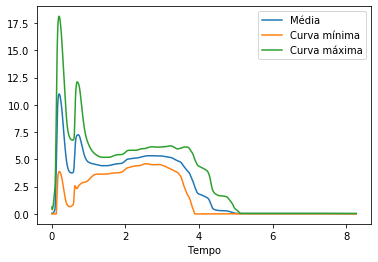

In [251]:
%%time
# SELECIONA DADOS E PLOTA O GRAFICO COM AS CURVAS MEDIA, MAXIMA E MINIMA
parametroStd = 1
normal = geraAssinaturaMedia(maquinasPorEstado[0], parametroStd)

ax = plt.gca()
normal.plot(kind='line',x='Tempo',y='Média',ax=ax)
normal.plot(kind='line',x='Tempo',y='Curva mínima',ax=ax)
normal.plot(kind='line',x='Tempo',y='Curva máxima',ax=ax)

CPU times: user 362 ms, sys: 14.4 ms, total: 376 ms
Wall time: 376 ms


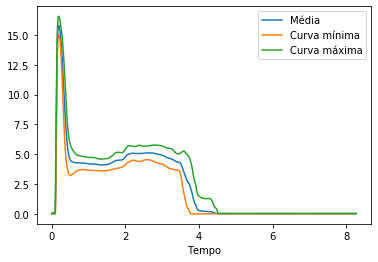

In [252]:
%%time
# MEDIA NORMAL COM FILTRO DE LEITURAS DESLOCADAS
normaisDeslocamentoFiltrado = filtroLeituraDeslocada(maquinasPorEstado[0], PontosFase[0])
parametroStd = 1
normal = geraAssinaturaMedia(normaisDeslocamentoFiltrado, parametroStd)

ax = plt.gca()
normal.plot(kind='line',x='Tempo',y='Média',ax=ax)
normal.plot(kind='line',x='Tempo',y='Curva mínima',ax=ax)
normal.plot(kind='line',x='Tempo',y='Curva máxima',ax=ax)

In [253]:
%%time
# CALCULA MEDIA DOS FINS DE CADA FASE PARA LEITURA NORMAL FILTRADA
dfPontosFase = pd.DataFrame(index =['Fim da Fase 0', 'Fim da Fase 1', 'Fim da Fase 2', 'Fim da Fase 3'])

for col in normaisDeslocamentoFiltrado:
    if (col != 't (s)'):
        pontos = calculaFases(normaisDeslocamentoFiltrado[col], 0.00101)
        dfPontosFase[col] = pontos


#calcula os pontos de troca de fase da assinatura
pontosMediaFilt = dfPontosFase.mean(axis=1)
print (pontosMediaFilt)

# Esse bloco calcula uma media dos valores normais para a fase inicial para ser comparada com as leituras em
# analise, a escolha desse metodo serve para contornar os casos em que o inicio da fase 1 esta deslocado.
mediaInicio = mediaFim = 0

for c in range(0, int(pontosMediaFilt.iloc[0])):
    mediaInicio += normal.iloc[c, 2]
mediaInicio = mediaInicio/int(pontosMediaFilt.iloc[0])
    
# Esse bloco e analogo ao primeiro, fazendo o mesmo processo mas para a fase final
for d in range(int(pontosMediaFilt.iloc[3]), amostragem):
    mediaFim += normal.iloc[d, 2]
mediaFim = mediaFim/int(pontosMediaFilt.iloc[3])

Fim da Fase 0      91.524096
Fim da Fase 1     533.144578
Fim da Fase 2    1814.827309
Fim da Fase 3    3774.182731
dtype: float64
CPU times: user 300 ms, sys: 1.96 ms, total: 302 ms
Wall time: 302 ms


In [255]:
%%time
# Cálculo dos erros quadráticos médios
eqmNormal = calculaEQM(normal, maquinasPorEstado[0], PontosFase[0], pontosMediaFilt, mediaInicio, mediaFim, amostragem)
eqmNormal = eqmNormal.transpose()
eqmNormal['rotulo'] = 0
eqmDefeito = calculaEQM(normal, maquinasPorEstado[1], PontosFase[1], pontosMediaFilt, mediaInicio, mediaFim, amostragem)
eqmDefeito = eqmDefeito.transpose()
eqmDefeito['rotulo'] = 1
eqmFalha = calculaEQM(normal, maquinasPorEstado[2], PontosFase[2], pontosMediaFilt, mediaInicio, mediaFim, amostragem)

CPU times: user 4min 59s, sys: 744 ms, total: 5min
Wall time: 5min


In [256]:
#junta os dataframes de normal e defeito
principal = pd.concat([eqmNormal, eqmDefeito])
principal

,EQM Fase 0,EQM Fase 1,EQM Fase 2,EQM Fase 3,EQM Fase 4,EQM Total,rotulo
MCH004W21A_20190820_041558,8.864300e+01,21.460193,0.135582,1.817919,0.002323,1.088575,0
MCH004W21A_20190820_070907,8.590719e+01,21.262522,0.145483,1.762224,0.002201,1.054986,0
MCH004W21A_20190821_030949,8.177630e+01,23.944937,0.128388,2.268086,0.002272,1.004957,0
MCH004W21A_20190825_221621,1.771398e+00,4.388138,0.104668,1.715708,0.002231,0.024639,0
MCH004W21A_20190825_223820,1.053733e+00,4.162413,0.112692,1.883851,0.002144,0.015775,0
MCH004W21B_20190824_051910,3.308477e-05,2.476821,0.046102,0.434976,0.002112,0.002474,0
MCH004W21B_20190824_223933,2.246865e-05,1.909824,0.045229,0.829967,0.002229,0.002570,0
MCH004W21B_20190821_030949,2.677407e-05,3.876162,0.053249,0.324954,0.002168,0.002689,0
MCH004W22A_20190824_223933,1.056095e-04,1.621433,0.147131,0.852656,0.002210,0.002534,0
MCH004W22A_20190825_235713,1.695865e-04,2.078544,0.144338,0.792064,0.002100,0.002474,0


In [257]:
#divide em dataframe de treino e teste
from sklearn.model_selection import train_test_split
train, test = train_test_split(principal, random_state=0)

In [258]:
#configura as features a ser analisadas, e treina o modelo
from sklearn.linear_model import LogisticRegression
feature_cols = ['EQM Fase 0', 'EQM Fase 1', 'EQM Fase 2', 'EQM Fase 3', 'EQM Fase 4']
X_treino = train.loc[:, feature_cols]
y_treino = train.rotulo
X_teste = test.loc[:, feature_cols]
y_teste = test.rotulo
modelo = LogisticRegression(C=15)
modelo.fit(X_treino, y_treino)

LogisticRegression(C=15, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [259]:
#testa a acuracia na base de treino e teste
print('Accuracy of Logistic regression classifier on training set: {:.2f}'
     .format(modelo.score(X_treino, y_treino)))
print('Accuracy of Logistic regression classifier on test set: {:.2f}'
     .format(modelo.score(X_teste, y_teste)))

Accuracy of Logistic regression classifier on training set: 0.79
Accuracy of Logistic regression classifier on test set: 0.80


In [228]:
X_treino.shape

(4056, 5)

In [210]:
predictions = modelo.predict_proba(X_teste)

In [211]:
predictions

array([[0.54432917, 0.45567083],
       [0.22421008, 0.77578992],
       [0.39487502, 0.60512498],
       ...,
       [0.5201114 , 0.4798886 ],
       [0.29716087, 0.70283913],
       [0.02167088, 0.97832912]])

In [212]:
y_teste

MCH009W22A_20200116_004909    0
MCH004W21A_20190830_074015    1
MCH011W22A_20200205_122033    1
MCH010W22B_20190907_173348    1
MCH009W21B_20190810_131058    1
MCH007W21A_20200227_024534    1
MCH010W22A_20190831_063203    1
MCH007W22B_20200327_151559    1
MCH007W22B_20190828_073926    1
MCH004W21B_20191011_011739    1
MCH009W21B_20190906_151405    1
MCH008W21B_20190823_100221    0
MCH009W22B_20190824_083110    1
MCH008W22A_20190902_223838    0
MCH010W22A_20190902_150711    0
MCH004W22B_20190821_101835    1
MCH007W22A_20190910_000226    1
MCH010W22A_20190823_215012    1
MCH011W22B_20191128_141728    1
MCH010W22A_20190903_184524    1
MCH009W21B_20190907_152818    1
MCH007W22A_20191229_161520    1
MCH010W22A_20190910_043127    0
MCH004W22A_20191226_065541    1
MCH004W22B_20190824_052012    0
MCH004W22A_20190826_000912    1
MCH007W22A_20190901_170633    1
MCH004W22A_20200204_124737    0
MCH010W22A_20190826_133544    1
MCH007W21B_20190907_130342    1
MCH010W22A_20190905_184334    1
MCH004W2

In [213]:
modelo.get_params()

{'C': 15,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [214]:
print (modelo.coef_)

[[ 0.00567786 -0.29220352  1.52350712  1.17343233  1.80294167]]
